In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
%matplotlib inline

In [36]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

In [37]:
titanic_data = pd.read_csv('data/titanic/train.csv')

In [38]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis='columns')
X = pd.get_dummies(X)
X = X.fillna({'Age': X.Age.median()}) # Можно вместо медианы попробовать подругому подобрать более подходящие данные, напрмер через машинное обучение и предсказание.
y = titanic_data.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [40]:
scores_data = pd.DataFrame()

In [41]:
# Поработаем с гиперпараметрами
max_depth_values = range(1, 100)
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [42]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.806780


In [43]:
# melt меняет формат DataFrame
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                           var_name='set_type', # Имя колонки с ключами
                           value_name='score') #
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


<AxesSubplot:xlabel='max_depth', ylabel='score'>

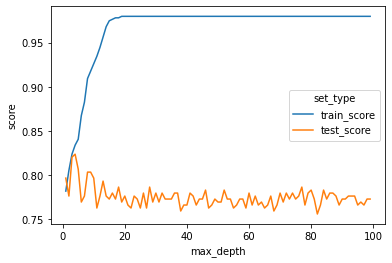

In [44]:
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

анализ графика:
train score:
- растет с увеличением глубины дерева
- что не всегда ведет к нахождению общих закономерностей в исследуемых данных

test score:
- изначально невелик (модель еще не доучилась)
- на промежутке 3-5 score максимален (оптимальное состояние: закономерность с изученных данных переносится на новые)
- с дальнейшим увеличением глубины test score начинает падать (переход от недообученности к переобученности)

# полезно, но не моё
Не сразу разобралась, что именно мы делаем на этом шаге, когда вернулась, поняла для многих скорее всего очевидную идею, но все же распишу ее:

0. Мы перебрали в цикле максимальную глубину от 1 до 100 и для каждого значения добавили в датафрейм точность на тренировочной и тестовой выборке - в итоге у нас есть 3 колонки.

1. Задача - изобразить на графике зависимость точности от глубины, и сделать это двумя линиями (train и test), если делать это на листе бумаги - проблем для человека вообще нет(даже если одна из линий нужна в форме котеночка), но мы выбираем такую функцию pandas, которой можем скормить x и только один y.

2. Нужно преобразовать scores_data так, чтобы для каждой строки были созданы 2 новые: одна со значением точности на тренировочных данных, другая на тестовых. В новом scores_data_long (он long, потому что в нем в два раза больше строк) останется колонка max_depth, которую мы будем использовать как x и появится всего одна колонка score, которую будем использовать как y. Дополнительная третья колонка set_type разделит строки для отрисовки двух линий.

# Кроссвалидация - один из способов избежать переобучения
То есть рубим данные на несколько частей.
На одной части мы обучаемся
На другой части мы крутим подборку гиперпараметров
И на части "финальный тест" уже проверяем как обучилась модель. Эта часть не должна была быть задействована ни разу при обучении модели. И полученный score на тестовых данных и будет ключевым значением к которому мы стремимся.

# Кроссвалидация

train dataset используется для тренировки модели, validation - для её проверки (подбора гиперпараметров например), тестовый датасет выступает как ещё один уровень проверки, которая происходит на не показанных модели ранее данных

https://scikit-learn.org/stable/modules/cross_validation.html
Кроссвалидация заключается в том, что мы разбиваем данный для тренеровки на например 5 частей и вначале тренеруемся на всех кроме первой части и тестируем на первой, потом на всех кроме 2-й части и тестируем на 2-й и т.п. 5 варинатов прогоняем. Таким образом получается, что каждый кусочек данных побывал и в обучении, и в тесте. Потом берем среднюю точность на каждом из 5-и вариантов и прогоняем для каждого гиперпараметра дерева, и эти среднии точности сравниваем:

In [45]:
from sklearn.model_selection import cross_val_score

In [46]:
# пересоздадим классификатор с максимальной глубиной 4
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [47]:
cross_val_score(clf, X_train, y_train, cv=5).mean()
# в итоге получаем набор точностей при обучении на разных частях тренеровочного куска данных

0.7886274509803922

In [48]:
# Возьмем среднее
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.7886274509803922

In [49]:
# Обновим алгоритм который использовали ранее, добавив значение кросс валидации
max_depth_values = range(1, 100)
scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]
                                    })
    scores_data = scores_data.append(temp_score_data)

In [50]:
scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.810169,0.803754


<AxesSubplot:xlabel='max_depth', ylabel='score'>

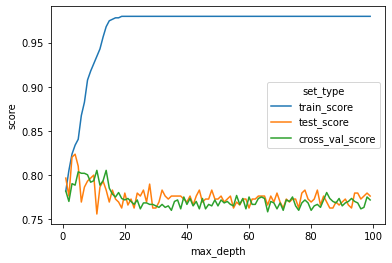

In [51]:
# Снова при помощи melt и отрисовки графика отрисуем линии. Так же добавим cross_val_score
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'],
                           value_vars=['train_score', 'test_score', 'cross_val_score'],
                           var_name='set_type',  # Имя колонки с ключами
                           value_name='score')  #
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [52]:
scores_data_long.query("set_type == 'cross_val_score'").head(20)
# Можем увидеть что на 11-м шаге наибольшая точность достигается

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.803754
203,6,cross_val_score,0.802073
204,7,cross_val_score,0.802059
205,8,cross_val_score,0.800364
206,9,cross_val_score,0.791947
207,10,cross_val_score,0.793627


In [54]:
# теперь при максимальной глубине 11 протестим финально дерево.
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11)

In [55]:
# проверим точность на значениях которые не видел классификатор ранее
cross_val_score(clf, X_test, y_test, cv=5).mean()
# Полученное значение можно использовать как финальное значение, которое мы получили при обучении с использованием кросс валидации на train множестве.

0.7932203389830509

In [57]:
# В предыдущей ячейке мы по новой проводили кросс валидацию, не обязательно это делать можно вычеслить точность сделав так:
best_clf.fit(X_train, y_train)
best_clf.score(X_test, y_test)

0.7762711864406779

# Не моё, но полезно
Тезисы, которые помогли разобраться в данном уроке, может кому тоже пригодится:

1. Перекрестная проверка не возвращает модель: кросс-валидация не является способом построения модели, которую можно применить к новым данным. При вызове cross_val_score строится несколько внутренних моделей, однако цель перекрестной проверки заключается только в том, чтобы оценить обобщающую способность данного алгоритма, обучив на определенном наборе данных. ("Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными" А.Мюллер, С.Гвидо)

2. При k-fold кросс-валидации обучающая выборка разбивается на (k-1) подвыборок и следующий алгоритм выполняется k раз:
- Модель обучается с использованием (k-1) подвыборок в качестве тренировочных данных;
- Полученная модель проверяется на оставшейся одной подвыборке (которая служит тестовым набором для вычисления точности).

3. Модель - это набор подготовленных данных (переменных) + метод (статистики, машинного обучения), подобранные для достижения цели исследования (проекта Data Science)
Процесс моделирования включает:
- Создание модели - планирование показателей (переменных) и выбор метода
- Тренировка модели
- Проверка адекватности и окончательный выбор модели
- Применение тренированной модели к незнакомым данным
Хорошая модель будет найдена (вероятно) только после многократного повторения первых 3-х шагов. ("Основы Data Science и Big Data. Python и наука о данных" Д.Силен, А.Мейсман, М.Али)

Таким образом (насколько я это понял),
1. Нужна хорошая модель, которая позволит достичь целей проекта, которую нужно обучить, протестировать, оценить и окончательно выбрать, после чего её можно будет применять "на производстве"
2. В данном уроке модель - это предобработанные данные Titanic + метод моделирования "Дерево решений", модель обучается методом fit() и тестируется 2-мя способами: score и cross_val_score
3. Метод cross_val_score() содержит (условно) процедуры обучения (fit) и проверки (score) , но он не может возвращать модель, которую можно применять к новым данным.

Для рассмотренного примера при работе с титаником не очень хорошо подходит понятие точность, поскольку пристутствует дисбаланс классов выжили условно 38% прогибли 62%. Соответственно для подобных ситуаций используют другие метрики, такие как: precision, recall, точность, полнота, f-мера, ROC-кривая.